In [3]:
#import Library

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score,classification_report, recall_score, precision_score

Read the Dataset

In [5]:
df = pd.read_csv("/Users/anupbanerjee/Downloads/Project 3/OnlineNewsPopularity/OnlineNewsPopularity.csv")
df.drop(["url"], axis = 1,inplace =True)
df.head(1)

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,731,12,219,0.663594,1.0,0.815385,4,2,1,0,...,0.1,0.7,-0.35,-0.6,-0.2,0.5,-0.1875,0.0,0.1875,593


In [6]:
df3 = df.copy(deep=True)
from sklearn.preprocessing import KBinsDiscretizer
# perform a k-merandom_search.best_params_ans discretization transform of the dataset
data = df3.values[:,-1:]
trans = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
data = trans.fit_transform(data)
# convert the array back to a dataframe
df3["share_class"] = data

### Outlier Treatment

In [7]:
c1 = df3[df3['share_class'] == 0]
c2 = df3[df3['share_class'] == 1]
c3 = df3[df3['share_class'] == 2]
c4 = df3[df3['share_class'] == 3]

In [8]:
for i in (c1.drop(["share_class","shares"], axis = 1).columns):
    Q1 = c1[i].quantile(0.25)
    Q3 = c1[i].quantile(0.75)
    IQR = Q3 - Q1
    
    c1[i][c1[i]>(Q3+1.5*IQR)] = Q3
    c1[i][c1[i]<(Q1-1.5*IQR)] = Q1
    
    
for i in (c2.drop(["share_class","shares"], axis = 1).columns):
    Q1 = c2[i].quantile(0.25)
    Q3 = c2[i].quantile(0.75)
    IQR = Q3 - Q1
    
    c2[i][c2[i]>(Q3+1.5*IQR)] = Q3
    c2[i][c2[i]<(Q1-1.5*IQR)] = Q1

for i in (c3.drop(["share_class","shares"], axis = 1).columns):
    Q1 = c3[i].quantile(0.25)
    Q3 = c3[i].quantile(0.75)
    IQR = Q3 - Q1
    
    c3[i][c3[i]>(Q3+1.5*IQR)] = Q3
    c3[i][c3[i]<(Q1-1.5*IQR)] = Q1

for i in (c4.drop(["share_class","shares"], axis = 1).columns):
    Q1 = c4[i].quantile(0.25)
    Q3 = c4[i].quantile(0.75)
    IQR = Q3 - Q1
    
    c4[i][c4[i]>(Q3+1.5*IQR)] = Q3
    c4[i][c4[i]<(Q1-1.5*IQR)] = Q1

In [9]:
datasets = [c1,c2,c3,c4]
dfd = pd.concat(datasets)

## Feature Engineering

In [10]:
c = ['n_tokens_content','n_tokens_title','num_imgs',"num_hrefs","num_self_hrefs"]
c1 = []
c2= []
for i in c: 
    dfd.loc[(dfd[i] <= np.percentile(dfd[i],33)), str(i)+"_class"] = "low"
    dfd.loc[(dfd[i] >np.percentile(dfd[i],33)) & (dfd[i]<= np.percentile(dfd[i],67)), str(i)+"_class"] = "Medium"
    dfd.loc[(dfd[i] >np.percentile(dfd[i],67)), str(i)+"_class"] = "high"
    c1.append(str(i)+"_class")
    c2.append(i)
dfd[c1].head(1)

,n_tokens_content_class,n_tokens_title_class,num_imgs_class,num_hrefs_class,num_self_hrefs_class
0,low,high,low,low,low


In [11]:
dfd["share_class"].value_counts()

2.0    11165
3.0     9989
0.0     9903
1.0     8587
Name: share_class, dtype: int64

### Classification of Share class

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
l = ["share_class"]
for i in l:
    dfd[i] = le.fit_transform(dfd[i])

### Modelling

In [13]:
X = dfd.drop(["n_tokens_title","n_tokens_content","shares","share_class",'num_hrefs',
              'num_self_hrefs', 'num_imgs',"shares",'share_class'], axis = 1)
y = dfd["share_class"]

In [14]:
X = pd.get_dummies(X,columns = ["n_tokens_content_class","n_tokens_title_class",'num_hrefs_class',
                                'num_self_hrefs_class','num_imgs_class'])

### Standard Scaler

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#for i not in 
X_std = sc.fit_transform(X)
X1 = pd.DataFrame(X_std,columns = X.columns)

In [16]:
lb_class = LabelEncoder()
le = ['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday','data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world']
for i in le:
    X1[i] = lb_class.fit_transform(X1[i])

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size = 0.3, random_state = 42, stratify = y)

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score,classification_report, recall_score, precision_score

lr = LogisticRegression(max_iter= 4000)
lr.fit(X_train,y_train)
y_train_predl = lr.predict(X_train)
y_train_probl = lr.predict_proba(X_train)
y_test_predl = lr.predict(X_test)
y_test_probl = lr.predict_proba(X_test)

In [20]:
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
print("Accuracy",accuracy_score(y_train,y_train_predl))
print("AUC train", roc_auc_score(y_train,y_train_probl, multi_class = "ovo"))
print("F1 train", f1_score(y_train,y_train_predl,average = 'weighted'))
print("recall",recall_score(y_train,y_train_predl,average = 'weighted'))
print("Precision",precision_score(y_train,y_train_predl,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_predl))
print("AUC test",roc_auc_score(y_test,y_test_probl,multi_class = "ovo"))
print("F1 test",f1_score(y_test,y_test_predl,average = 'weighted'))
print("recall",recall_score(y_test,y_test_predl,average = 'weighted'))
print("Precision",precision_score(y_test,y_test_predl,average = 'weighted'))

Accuracy 0.6026666666666667
AUC train 0.8481035987522784
F1 train 0.597231682720183
recall 0.6026666666666667
Precision 0.5960529773988643


Accuracy 0.6030771817723222
AUC test 0.8500240376443701
F1 test 0.5977910261396412
recall 0.6030771817723222
Precision 0.5967243084236568


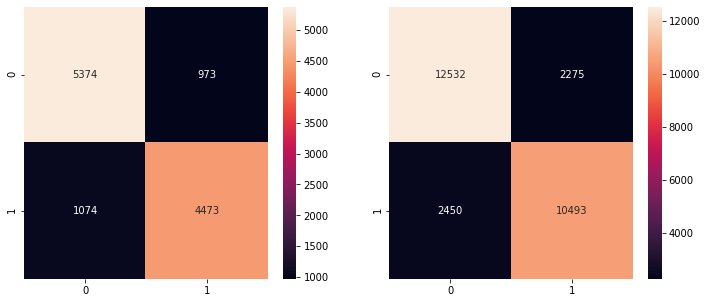

In [104]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred),fmt = 'd',annot = True,ax = axes[1])
#plt.savefig("Logistic median.png")
plt.show()

### Logistic Regression with Gridsearch

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(max_iter = 4000)
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'penalty': 'l2'}
accuracy : 0.5993513513513513


In [25]:
logreg_C = LogisticRegression(**logreg_cv.best_params_,max_iter = 3000)
logreg_C.fit(X_train,y_train)
y_train_predl = logreg_C.predict(X_train)
y_train_probl = logreg_C.predict_proba(X_train)[:,1]
y_test_predl = logreg_C.predict(X_test)
y_test_probl = logreg_C.predict_proba(X_test)[:,1]
#Scores
print("Accuracy",accuracy_score(y_train,y_train_predl))
#print("AUC train", roc_auc_score(y_train,y_train_probl, multi_class = "ovr"))
print("F1 train", f1_score(y_train,y_train_predl,average = 'weighted'))
print("recall",recall_score(y_train,y_train_predl,average = 'weighted'))
print("Precision",precision_score(y_train,y_train_predl,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_predl))
#print("AUC test",roc_auc_score(y_test,y_test_probl,multi_class = "ovr"))
print("F1 test",f1_score(y_test,y_test_predl,average = 'weighted'))
print("recall",recall_score(y_test,y_test_predl,average = 'weighted'))
print("Precision",precision_score(y_test,y_test_predl,average = 'weighted'))

Accuracy 0.6025585585585586
F1 train 0.5971417944211302
recall 0.6025585585585586
Precision 0.5959557313999051


Accuracy 0.6029090297629056
F1 test 0.5976329332343117
recall 0.6029090297629056
Precision 0.5965411469796899


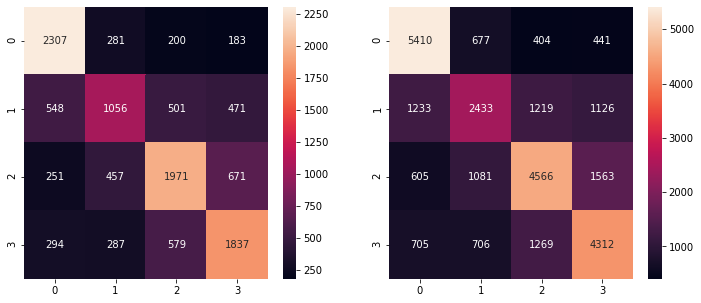

In [27]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_predl),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_predl),fmt = 'd',annot = True,ax = axes[1])
#plt.savefig("Logistic median.png")
plt.show()

### Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier as dct
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
dt = dct()
dt.fit(X_train,y_train)
y_train_pred = dt.predict(X_train)
y_train_prob = dt.predict_proba(X_train)
y_test_pred = dt.predict(X_test)
y_test_prob = dt.predict_proba(X_test)
print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob, multi_class = "ovo"))
print("F1 train", f1_score(y_train,y_train_pred,average = 'weighted'))
print("recall",recall_score(y_train,y_train_pred,average = 'weighted'))
print("Precision",precision_score(y_train,y_train_pred,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob,multi_class = "ovo"))
print("F1 test",f1_score(y_test,y_test_pred,average = 'weighted'))
print("recall",recall_score(y_test,y_test_pred,average = 'weighted'))
print("Precision",precision_score(y_test,y_test_pred,average = 'weighted'))

Accuracy 1.0
AUC train 1.0
F1 train 1.0
recall 1.0
Precision 1.0


Accuracy 0.8230200100891205
AUC test 0.8814913169644966
F1 test 0.8230246047278688
recall 0.8230200100891205
Precision 0.823060021266095


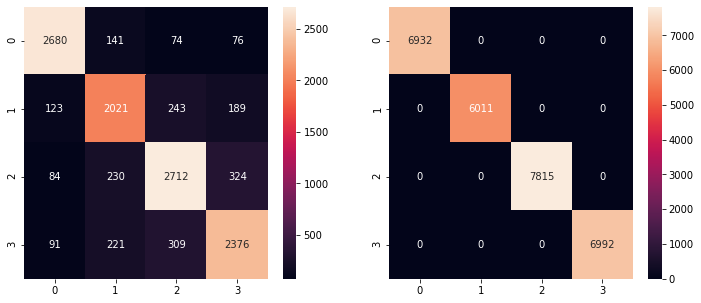

In [29]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred),fmt = 'd',annot = True,ax = axes[1])
#plt.savefig("Logistic median.png")
plt.show()

### Decision Tree with Grid search

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='weighted')
dt = dct(random_state = 3)
params = {"max_depth": [6,8,10,12,14,16], 'min_samples_split':[2,4,6,8,10,12],'min_samples_leaf':[1,2,4,6]}

gsearch_dt = GridSearchCV(dt,param_grid=params, cv = 6,scoring = ['f1_weighted','precision_weighted'],return_train_score=True,n_jobs = -1, refit = 'f1_weighted')

gsearch_dt.fit(X1,y)
gsearch_dt.best_params_

{'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}

In [35]:
from sklearn.ensemble import BaggingClassifier
dt = dct(max_depth = 19, min_samples_leaf = 6, min_samples_split = 2)
bc = BaggingClassifier(base_estimator=dt, n_estimators=2000, random_state=1, oob_score=True)
dt.fit(X_train,y_train)
y_train_pred_dt = dt.predict(X_train)
y_train_prob_dt = dt.predict_proba(X_train)
y_test_pred_dt = dt.predict(X_test)
y_test_prob_dt = dt.predict_proba(X_test)
print("Accuracy",accuracy_score(y_train,y_train_pred_dt))
print("AUC train", roc_auc_score(y_train,y_train_prob_dt, multi_class = "ovo"))
print("F1 train", f1_score(y_train,y_train_pred_dt,average = 'weighted'))
print("recall",recall_score(y_train,y_train_pred_dt,average = 'weighted'))
print("Precision",precision_score(y_train,y_train_pred_dt,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred_dt))
print("AUC test",roc_auc_score(y_test,y_test_prob_dt,multi_class = "ovo"))
print("F1 test",f1_score(y_test,y_test_pred_dt,average = 'weighted'))
print("recall",recall_score(y_test,y_test_pred_dt,average = 'weighted'))
print("Precision",precision_score(y_test,y_test_pred_dt,average = 'weighted'))


Accuracy 0.8719639639639639
AUC train 0.9844301037769517
F1 train 0.8719683085397262
recall 0.8719639639639639
Precision 0.8778476048886416


Accuracy 0.8178913738019169
AUC test 0.9525808758652671
F1 test 0.8172593470548026
recall 0.8178913738019169
Precision 0.8230072268826102


In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
scoring = {'accuracy' : make_scorer(accuracy_score)}



model4 = dct(max_depth = 19, min_samples_leaf = 6, min_samples_split = 2)
results_dt = cross_validate(model4, X_test, y_test, cv=10, scoring = scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(results_dt['test_accuracy'])*100, np.std(results_dt['test_accuracy']) * 2))

Accuracy: 78.11 (+/- 0.03)


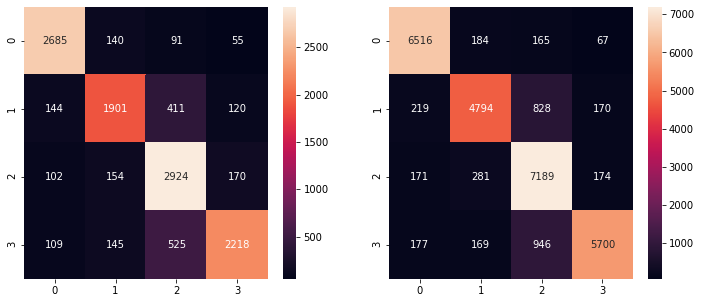

In [170]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred_dt),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred_dt),fmt = 'd',annot = True,ax = axes[1])
plt.savefig("4 DT CM.png")
plt.show()

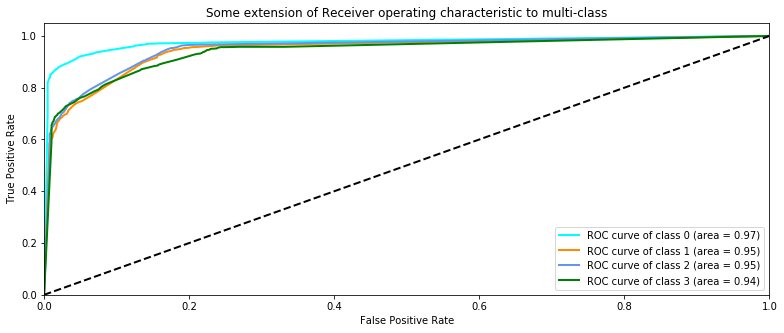

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from numpy import interp
from sklearn.metrics import roc_auc_score



y_test1 = label_binarize(y_test, classes=[0, 1, 2,3])
n_classes = 4



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_test_prob_dt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_test_prob_dt.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure(figsize = (13,5))


colors = cycle(['aqua', 'darkorange', 'cornflowerblue',"green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("4 DT ROC.png")
plt.show()

### RandomForest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=3)

rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_train_prob = rf.predict_proba(X_train)

y_test_pred = rf.predict(X_test)
y_test_prob = rf.predict_proba(X_test)


print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob, multi_class = "ovo"))
print("F1 train", f1_score(y_train,y_train_pred,average = 'weighted'))
print("recall",recall_score(y_train,y_train_pred,average = 'weighted'))
print("Precision",precision_score(y_train,y_train_pred,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob,multi_class = "ovo"))
print("F1 test",f1_score(y_test,y_test_pred,average = 'weighted'))
print("recall",recall_score(y_test,y_test_pred,average = 'weighted'))
print("Precision",precision_score(y_test,y_test_pred,average = 'weighted'))

Accuracy 1.0
AUC train 1.0
F1 train 1.0
recall 1.0
Precision 1.0


Accuracy 0.8683369766268707
AUC test 0.977751967807051
F1 test 0.8678443348816589
recall 0.8683369766268707
Precision 0.8696405427836108


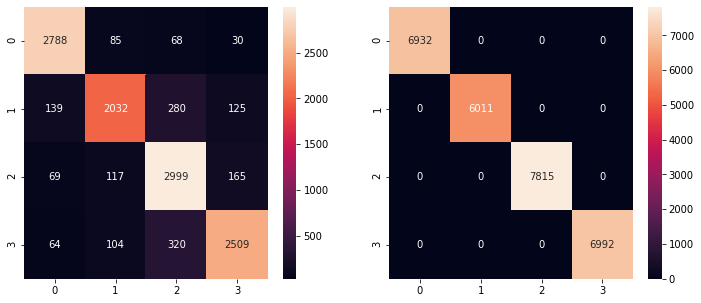

In [38]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred),fmt = 'd',annot = True,ax = axes[1])
#plt.savefig("Logistic median.png")
plt.show()

## Feature Selection with Best Features

In [21]:
best_features = pd.DataFrame(rf.feature_importances_,index=X.columns,columns=['value'])
b = list(best_features[best_features['value'] >0].index)

In [22]:
X_best = X1[b]

In [23]:
X_best.shape

(39644, 56)

In [24]:
X1.shape

(39644, 69)

In [25]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_best,y,test_size = 0.3, random_state = 42, stratify = y)

### RandomForest with Randomized search

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()
skf = StratifiedKFold(n_splits=6, random_state = 1001)
param_rf = {
    'n_estimators': sp_randint(50, 200),
    'max_features': sp_randint(1, 14),
    'max_depth': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 20),
    'min_samples_split': sp_randint(2, 20)}

rsearch_rf = RandomizedSearchCV(rf, param_distributions=param_rf, scoring=['f1_weighted','precision_weighted'], n_iter=100,
                            cv=skf.split(X_train1,y_train1), n_jobs=-1, return_train_score=True, refit = 'f1_weighted')

rsearch_rf.fit(X_train1, y_train1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fab42a17dd0>,
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fab28e2ded0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fab28e2dc50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fab34b8c490>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fab33931150>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fab54754f50>},
                   refit='f1_weighted', return_train_score=True,
                   scoring=['f1_weighted', 'precision_weighted'])

In [46]:
rsearch_rf.best_params_

{'max_depth': 9,
 'max_features': 12,
 'min_samples_leaf': 12,
 'min_samples_split': 15,
 'n_estimators': 122}

In [47]:


rf = RandomForestClassifier(**rsearch_rf.best_params_, oob_score=True,  random_state=3)

rf.fit(X_train1, y_train1)

y_train_pred_rf1 = rf.predict(X_train1)
y_train_prob_rf1 = rf.predict_proba(X_train1)

y_test_pred_rf1 = rf.predict(X_test1)
y_test_prob_rf1 = rf.predict_proba(X_test1)


print("Accuracy",accuracy_score(y_train1,y_train_pred_rf1))
print("AUC train", roc_auc_score(y_train1,y_train_prob_rf1, multi_class = "ovo"))
print("F1 train", f1_score(y_train1,y_train_pred_rf1,average = 'weighted'))
print("recall",recall_score(y_train1,y_train_pred_rf1,average = 'weighted'))
print("Precision",precision_score(y_train1,y_train_pred_rf1,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test1,y_test_pred_rf1))
print("AUC test",roc_auc_score(y_test1,y_test_prob_rf1,multi_class = "ovo"))
print("F1 test",f1_score(y_test1,y_test_pred_rf1,average = 'weighted'))
print("recall",recall_score(y_test1,y_test_pred_rf1,average = 'weighted'))
print("Precision",precision_score(y_test1,y_test_pred_rf1,average = 'weighted'))

Accuracy 0.7961801801801802
AUC train 0.9491150087361385
F1 train 0.7938891754083183
recall 0.7961801801801802
Precision 0.8121474531330186


Accuracy 0.7787960316125778
AUC test 0.9440615716117575
F1 test 0.7761469629560703
recall 0.7787960316125778
Precision 0.7943031389682067


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

rf = RandomForestClassifier()
skf = StratifiedKFold(n_splits=6, shuffle = True,random_state = 1001)
param_rf = {
    'n_estimators': sp_randint(50, 200),
    'max_features': sp_randint(1, 14),
    'max_depth': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 20),
    'min_samples_split': sp_randint(2, 20)}

rsearch_rf = RandomizedSearchCV(rf, param_distributions=param_rf, scoring=['f1_weighted','precision_weighted'], n_iter=100,
                            cv=skf.split(X_train,y_train), n_jobs=-1, return_train_score=True, refit = 'f1_weighted')

rsearch_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fbb8aa99ed0>,
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbb8a84aa90>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbb8a84a690>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbb8a84af50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbb8a84afd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbb8a84a650>},
                   refit='f1_weighted', return_train_score=True,
                   scoring=['f1_weighted', 'precision_weighted'])

In [29]:
rf = RandomForestClassifier(**rsearch_rf.best_params_, oob_score=True,  random_state=3)

rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_train_prob_rf = rf.predict_proba(X_train)

y_test_pred_rf = rf.predict(X_test)
y_test_prob_rf = rf.predict_proba(X_test)

print("Accuracy",accuracy_score(y_train,y_train_pred_rf))
print("AUC train", roc_auc_score(y_train,y_train_prob_rf, multi_class = "ovo"))
print("F1 train", f1_score(y_train,y_train_pred_rf,average = 'weighted'))
print("recall",recall_score(y_train,y_train_pred_rf,average = 'weighted'))
print("Precision",precision_score(y_train,y_train_pred_rf,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred_rf))
print("AUC test",roc_auc_score(y_test,y_test_prob_rf,multi_class = "ovo"))
print("F1 test",f1_score(y_test,y_test_pred_rf,average = 'weighted'))
print("recall",recall_score(y_test,y_test_pred_rf,average = 'weighted'))
print("Precision",precision_score(y_test,y_test_pred_rf,average = 'weighted'))

Accuracy 0.8004324324324325
AUC train 0.9515570286010648
F1 train 0.7973558672832955
recall 0.8004324324324325
Precision 0.8149329668950224


Accuracy 0.7815705397679502
AUC test 0.9449589188395541
F1 test 0.7779438290121851
recall 0.7815705397679502
Precision 0.7975169014087636


In [30]:
best_features = pd.DataFrame(rf.feature_importances_,index=X.columns,columns=['value'])
b = list(best_features[best_features['value'] >0].index)

In [31]:
X_best1 = X1[b]

In [32]:
X_best1.shape

(39644, 56)

In [33]:
X1.shape

(39644, 69)

In [35]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_best1,y,test_size = 0.3, random_state = 42, stratify = y)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

rf = RandomForestClassifier()
skf = StratifiedKFold(n_splits=6, shuffle = True,random_state = 1001)
param_rf = {
    'n_estimators': sp_randint(50, 200),
    'max_features': sp_randint(1, 14),
    'max_depth': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 20),
    'min_samples_split': sp_randint(2, 20)}

rsearch_rf = RandomizedSearchCV(rf, param_distributions=param_rf, scoring=['f1_weighted','precision_weighted'], n_iter=100,
                            cv=skf.split(X_train1,y_train1), n_jobs=-1, return_train_score=True, refit = 'f1_weighted')

rsearch_rf.fit(X_train1, y_train1)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fbb8a739650>,
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbb867b4c50>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbb867b4f90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbb867b4710>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbb867b4dd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbb8a84a090>},
                   refit='f1_weighted', return_train_score=True,
                   scoring=['f1_weighted', 'precision_weighted'])

In [37]:
rf = RandomForestClassifier(**rsearch_rf.best_params_, oob_score=True,  random_state=3)

rf.fit(X_train1, y_train1)

y_train_pred_rf = rf.predict(X_train1)
y_train_prob_rf = rf.predict_proba(X_train1)

y_test_pred_rf = rf.predict(X_test1)
y_test_prob_rf = rf.predict_proba(X_test1)

print("Accuracy",accuracy_score(y_train1,y_train_pred_rf))
print("AUC train", roc_auc_score(y_train1,y_train_prob_rf, multi_class = "ovo"))
print("F1 train", f1_score(y_train1,y_train_pred_rf,average = 'weighted'))
print("recall",recall_score(y_train1,y_train_pred_rf,average = 'weighted'))
print("Precision",precision_score(y_train1,y_train_pred_rf,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test1,y_test_pred_rf))
print("AUC test",roc_auc_score(y_test1,y_test_prob_rf,multi_class = "ovo"))
print("F1 test",f1_score(y_test1,y_test_pred_rf,average = 'weighted'))
print("recall",recall_score(y_test1,y_test_pred_rf,average = 'weighted'))
print("Precision",precision_score(y_test1,y_test_pred_rf,average = 'weighted'))

Accuracy 0.8039279279279279
AUC train 0.9526270319991991
F1 train 0.8009899470238339
recall 0.8039279279279279
Precision 0.8175315476147391


Accuracy 0.7843450479233227
AUC test 0.9453278826030768
F1 test 0.7807130252365033
recall 0.7843450479233227
Precision 0.7991868352635161


In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
scoring = {'accuracy' : make_scorer(accuracy_score)}
model = RandomForestClassifier(**rsearch_rf.best_params_, oob_score=True,  random_state=3)
resultsr = cross_validate(model, X_test1, y_test1, cv=10, scoring = scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(resultsr['test_accuracy']), np.std(resultsr['test_accuracy']) * 2))

Accuracy: 0.78 (+/- 0.03)


In [310]:
resultsr

{'fit_time': array([1.76473808, 2.36114216, 2.74102712, 2.07893991, 2.06817389,
        1.99464297, 1.79474306, 1.77367401, 1.74931216, 1.84962392]),
 'score_time': array([0.05121112, 0.1314187 , 0.05219483, 0.05645108, 0.05104709,
        0.0552001 , 0.05219698, 0.04750085, 0.04785991, 0.05161786]),
 'test_accuracy': array([0.90264817, 0.92055485, 0.88272383, 0.84867591, 0.87840565,
        0.87108981, 0.86755802, 0.89177598, 0.91246216, 0.87563068])}

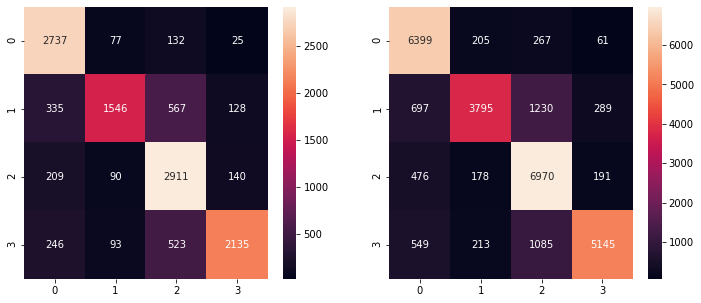

In [40]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred_rf),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred_rf),fmt = 'd',annot = True,ax = axes[1])
#plt.savefig("4 RF CM.png")
plt.show()

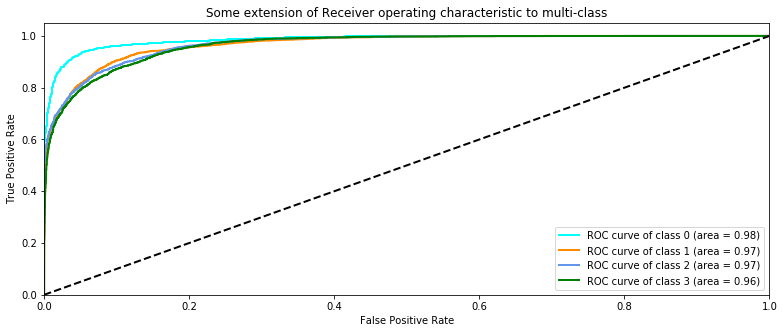

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from numpy import interp
from sklearn.metrics import roc_auc_score



y_test1 = label_binarize(y_test, classes=[0, 1, 2,3])
n_classes = 4



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_test_prob_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_test_prob_rf.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure(figsize = (13,5))


colors = cycle(['aqua', 'darkorange', 'cornflowerblue',"green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("4 RF ROC.png")
plt.show()

In [ ]:
### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_train_pred = knn.predict(X_train)
y_train_prob = knn.predict_proba(X_train)[:,1]
y_test_pred = knn.predict(X_test)
y_test_prob = knn.predict_proba(X_test)[:,1] 

print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob))
print("F1 train", f1_score(y_train,y_train_pred))
print("recall",recall_score(y_train,y_train_pred))
print("Precision",precision_score(y_train,y_train_pred))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob))
print("F1 test",f1_score(y_test,y_test_pred))
print("recall",recall_score(y_test,y_test_pred))
print("Precision",precision_score(y_test,y_test_pred))

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_pred),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_pred),fmt = 'd',annot = True,ax = axes[1])
plt.savefig("Logistic mean.png")
plt.show()

In [41]:
from xgboost import XGBClassifier

XGB = XGBClassifier()
XGB.fit(X_train, y_train)


y_train_pred = XGB.predict(X_train)
y_train_prob = XGB.predict_proba(X_train)

y_test_pred = XGB.predict(X_test)
y_test_prob = XGB.predict_proba(X_test)


print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob, multi_class = "ovo"))
print("F1 train", f1_score(y_train,y_train_pred,average = 'weighted'))
print("recall",recall_score(y_train,y_train_pred,average = 'weighted'))
print("Precision",precision_score(y_train,y_train_pred,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob,multi_class = "ovo"))
print("F1 test",f1_score(y_test,y_test_pred,average = 'weighted'))
print("recall",recall_score(y_test,y_test_pred,average = 'weighted'))
print("Precision",precision_score(y_test,y_test_pred,average = 'weighted'))

Accuracy 0.9892972972972973
AUC train 0.9997473029112327
F1 train 0.9892972513426848
recall 0.9892972972972973
Precision 0.9893818616655032


Accuracy 0.9155036152682025
AUC test 0.9932958422725688
F1 test 0.9156012927728239
recall 0.9155036152682025
Precision 0.916396527783173


In [42]:
from xgboost import XGBClassifier

XGB = XGBClassifier()
XGB.fit(X_train1, y_train1)


y_train_pred = XGB.predict(X_train1)
y_train_prob = XGB.predict_proba(X_train1)

y_test_pred = XGB.predict(X_test1)
y_test_prob = XGB.predict_proba(X_test1)


print("Accuracy",accuracy_score(y_train1,y_train_pred))
print("AUC train", roc_auc_score(y_train1,y_train_prob, multi_class = "ovo"))
print("F1 train", f1_score(y_train1,y_train_pred,average = 'weighted'))
print("recall",recall_score(y_train1,y_train_pred,average = 'weighted'))
print("Precision",precision_score(y_train1,y_train_pred,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test1,y_test_pred))
print("AUC test",roc_auc_score(y_test1,y_test_prob,multi_class = "ovo"))
print("F1 test",f1_score(y_test1,y_test_pred,average = 'weighted'))
print("recall",recall_score(y_test1,y_test_pred,average = 'weighted'))
print("Precision",precision_score(y_test1,y_test_pred,average = 'weighted'))

Accuracy 0.9892972972972973
AUC train 0.9997473029112327
F1 train 0.9892972513426848
recall 0.9892972972972973
Precision 0.9893818616655032


Accuracy 0.9155036152682025
AUC test 0.9932958422725688
F1 test 0.9156012927728239
recall 0.9155036152682025
Precision 0.916396527783173


In [43]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import time

params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
    }



xgb = XGBClassifier(learning_rate=0.02, n_estimators=600,
                silent=True, nthread=1)

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, 
                                   scoring=['f1_macro','precision_macro'],
                                   n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, refit = 'f1_macro',return_train_score=True)


random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 39.2min finished


[05:32:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fbb8cca1250>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing...
                                           scale_pos_weight=None, silent=True,
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                        

In [44]:
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 5,
 'max_depth': 5,
 'gamma': 5,
 'colsample_bytree': 1.0}

In [45]:
xgb = XGBClassifier(**random_search.best_params_,learning_rate=0.02, n_estimators=600,
                silent=True, nthread=1)
xgb.fit(X_train,y_train)
y_train_pred = xgb.predict(X_train)
y_train_prob = xgb.predict_proba(X_train)

y_test_pred = xgb.predict(X_test)
y_test_prob = xgb.predict_proba(X_test)

print("Accuracy",accuracy_score(y_train,y_train_pred))
print("AUC train", roc_auc_score(y_train,y_train_prob, multi_class = "ovo"))
print("F1 train", f1_score(y_train,y_train_pred,average = 'weighted'))
print("recall",recall_score(y_train,y_train_pred,average = 'weighted'))
print("Precision",precision_score(y_train,y_train_pred,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_pred))
print("AUC test",roc_auc_score(y_test,y_test_prob,multi_class = "ovo"))
print("F1 test",f1_score(y_test,y_test_pred,average = 'weighted'))
print("recall",recall_score(y_test,y_test_pred,average = 'weighted'))
print("Precision",precision_score(y_test,y_test_pred,average = 'weighted'))

[10:52:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy 0.918990990990991
AUC train 0.9933262486881841
F1 train 0.9190506325457578
recall 0.918990990990991
Precision 0.9214740347006773


Accuracy 0.9075163948209181
AUC test 0.9917402399227931
F1 test 0.907616298330529
recall 0.9075163948209181
Precision 0.9099695972716911


# Best XGB

In [46]:
best_features_X = pd.DataFrame(xgb.feature_importances_,index=X.columns,columns=['value'])
b = list(best_features_X[best_features_X['value'] >0].index)

In [47]:
X_best_X = X1[b]

In [48]:
X_best_X.shape

(39644, 50)

In [49]:
X1.shape

(39644, 69)

In [50]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_best_X,y,test_size = 0.3, random_state = 42, stratify = y)

In [51]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import time

params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
    }



xgb1 = XGBClassifier(learning_rate=0.02, n_estimators=600,
                silent=True, nthread=1)

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search1 = RandomizedSearchCV(xgb1, param_distributions=params, n_iter=param_comb, 
                                   scoring=['f1_macro'],
                                   n_jobs=-1, cv= 5, verbose=3, refit = 'f1_macro')


random_search1.fit(X_train1, y_train1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 57.1min finished


[15:16:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=600,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [52]:
xgb = XGBClassifier(**random_search.best_params_,learning_rate=0.02, n_estimators=600,
                silent=True, nthread=1)
xgb.fit(X_train1,y_train1)
y_train_pred = xgb.predict(X_train1)
y_train_prob = xgb.predict_proba(X_train1)

y_test_pred = xgb.predict(X_test1)
y_test_prob = xgb.predict_proba(X_test1)

print("Accuracy",accuracy_score(y_train1,y_train_pred))
print("AUC train", roc_auc_score(y_train1,y_train_prob, multi_class = "ovo"))
print("F1 train", f1_score(y_train1,y_train_pred,average = 'weighted'))
print("recall",recall_score(y_train1,y_train_pred,average = 'weighted'))
print("Precision",precision_score(y_train1,y_train_pred,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test1,y_test_pred))
print("AUC test",roc_auc_score(y_test1,y_test_prob,multi_class = "ovo"))
print("F1 test",f1_score(y_test1,y_test_pred,average = 'weighted'))
print("recall",recall_score(y_test1,y_test_pred,average = 'weighted'))
print("Precision",precision_score(y_test1,y_test_pred,average = 'weighted'))

[19:22:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy 0.9190630630630631
AUC train 0.9933328191773704
F1 train 0.9191248700548142
recall 0.9190630630630631
Precision 0.9215228797312388


Accuracy 0.9076845468303346
AUC test 0.9917487742537081
F1 test 0.9077856060444452
recall 0.9076845468303346
Precision 0.9101545876405469


In [55]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

n_iterations = 10
n_size = int(len(data) * 0.50)
# run bootstrap
stats = list()
for i in range(n_iterations):
    # prepare train and test sets
    train = resample(X.values, n_samples=n_size)
    test = np.array([x for x in X.values if x.tolist() not in train.tolist()])
    # fit model
    model = DecisionTreeClassifier()
    model.fit(train, y.values)
    # evaluate model
    predictions = model.predict(test)
    score = accuracy_score(y, predictions)
    print(score)
    stats.append(score)
# plot scores
pyplot.hist(stats)
pyplot.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, numpy.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, numpy.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))


KeyboardInterrupt: 

In [229]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
scoring = {'accuracy' : make_scorer(accuracy_score)}
skf = StratifiedKFold(n_splits=5,)
model2 = XGBClassifier(**random_search1.best_params_,learning_rate=0.02, n_estimators=600,
                silent=True, nthread=1)
results = cross_validate(model2, X_train1, y_train1, cv=10, scoring = scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(results['test_accuracy']), np.std(results['test_accuracy']) * 2))

[02:11:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:13:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:15:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

In [176]:
print("Accuracy",accuracy_score(y_train,y_train_predX))
print("AUC train", roc_auc_score(y_train,y_train_probX, multi_class = "ovo"))
print("F1 train", f1_score(y_train,y_train_predX,average = 'weighted'))
print("recall",recall_score(y_train,y_train_predX,average = 'weighted'))
print("Precision",precision_score(y_train,y_train_predX,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_predX))
print("AUC test",roc_auc_score(y_test,y_test_probX,multi_class = "ovo"))
print("F1 test",f1_score(y_test,y_test_predX,average = 'weighted'))
print("recall",recall_score(y_test,y_test_predX,average = 'weighted'))
print("Precision",precision_score(y_test,y_test_predX,average = 'weighted'))

Accuracy 0.9256936936936937
AUC train 0.9942782322409252
F1 train 0.9257424212033983
recall 0.9256936936936937
Precision 0.9280164890691389


Accuracy 0.908777534891542
AUC test 0.9919473497363626
F1 test 0.9088696203183771
recall 0.908777534891542
Precision 0.9109593726828038


In [214]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
scoring = {'accuracy' : make_scorer(accuracy_score)}
modelX = XGBClassifier(**random_search.best_params_,learning_rate=0.02, n_estimators=600,silent=True, nthread=1)
resultsX = cross_validate(model, X1, y, cv=10, scoring = scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(resultsX['test_accuracy']), np.std(resultsX['test_accuracy']) * 2))

Accuracy: 0.89 (+/- 0.04)


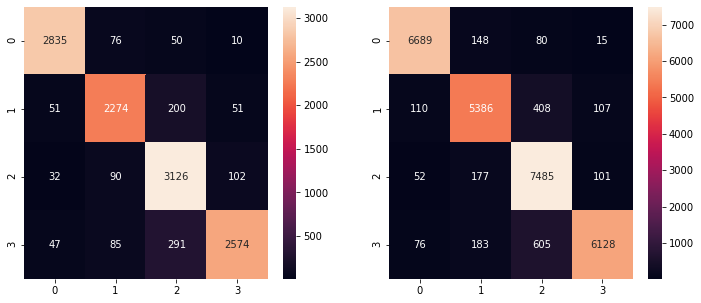

In [180]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_predX),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_predX),fmt = 'd',annot = True,ax = axes[1])
plt.savefig("4 XGB CM.png")
plt.show()

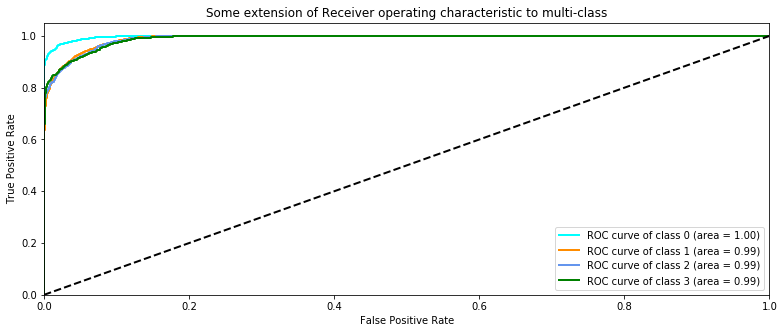

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from numpy import interp
from sklearn.metrics import roc_auc_score



y_test1 = label_binarize(y_test, classes=[0, 1, 2,3])
n_classes = 4



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_test_probX[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_test_probX.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure(figsize = (13,5))


colors = cycle(['aqua', 'darkorange', 'cornflowerblue',"green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("4 XGB ROC.png")
plt.show()

In [177]:
means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']
params = random_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyError: 'mean_test_score'

In [211]:
random_search.cv_results_

{'mean_fit_time': array([439.09961963, 531.83643327, 363.96383843, 422.22082005,
        392.10375075]),
 'std_fit_time': array([67.77971588, 17.70197122, 58.58581907, 65.11645554, 31.06309882]),
 'mean_score_time': array([1.90689173, 2.0843996 , 1.51155877, 1.60140476, 2.14319496]),
 'std_score_time': array([0.62353176, 0.96112339, 0.28129756, 0.65207953, 0.34241034]),
 'param_subsample': masked_array(data=[1.0, 0.6, 0.6, 0.8, 0.8],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[10, 10, 1, 1, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5, 5, 3, 5, 5],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[5, 1, 0.5, 1, 0.5],
              mask=[False, False, False, False, False],
       

In [53]:
import lightgbm as lgb
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

lgbc = lgb.LGBMClassifier(random_state = 3)

params = {'n_estimators' :sp_randint(70,200),
          'max_depth': sp_randint(1,10),
          'learning_rate': sp_uniform(0,0.5)}
skf = StratifiedKFold(n_splits=5, random_state = 1001)
rsearch_lgbm = RandomizedSearchCV(lgbc, param_distributions = params, cv = skf, n_iter=10, n_jobs = 2, scoring = ['f1_macro','precision_macro'], refit ='f1_macro')

rsearch_lgbm.fit(X_train,y_train)
rsearch_lgbm.best_params_

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


{'learning_rate': 0.18390402513009568, 'max_depth': 5, 'n_estimators': 170}

In [94]:
rsearch_lgbm.best_params_

{'learning_rate': 0.3442287883514442, 'max_depth': 3, 'n_estimators': 110}

In [95]:
gbc_r = lgb.LGBMClassifier(**rsearch_lgbm.best_params_,random_state = 3)
gbc_r.fit(X_train,y_train)
y_train_predL = gbc_r.predict(X_train)
y_train_probL = gbc_r.predict_proba(X_train)

y_test_predL = gbc_r.predict(X_test)
y_test_probL = gbc_r.predict_proba(X_test)


print("Accuracy",accuracy_score(y_train,y_train_predL))
print("AUC train", roc_auc_score(y_train,y_train_probL, multi_class = "ovo"))
print("F1 train", f1_score(y_train,y_train_predL,average = 'weighted'))
print("recall",recall_score(y_train,y_train_predL,average = 'weighted'))
print("Precision",precision_score(y_train,y_train_predL,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test,y_test_predL))
print("AUC test",roc_auc_score(y_test,y_test_probL,multi_class = "ovo"))
print("F1 test",f1_score(y_test,y_test_predL,average = 'weighted'))
print("recall",recall_score(y_test,y_test_predL,average = 'weighted'))
print("Precision",precision_score(y_test,y_test_predL,average = 'weighted'))

Accuracy 0.926990990990991
AUC train 0.9947652100078502
F1 train 0.9269646843150923
recall 0.926990990990991
Precision 0.9284442756631154


Accuracy 0.9144106272069952
AUC test 0.9930975128344022
F1 test 0.9144868725668714
recall 0.9144106272069952
Precision 0.9158803493133826


Accuracy 0.9256936936936937
AUC train 0.9942782322409252
F1 train 0.9257424212033983
recall 0.9256936936936937
Precision 0.9280164890691389


Accuracy 0.908777534891542
AUC test 0.9919473497363626
F1 test 0.9088696203183771
recall 0.908777534891542
Precision 0.9109593726828038


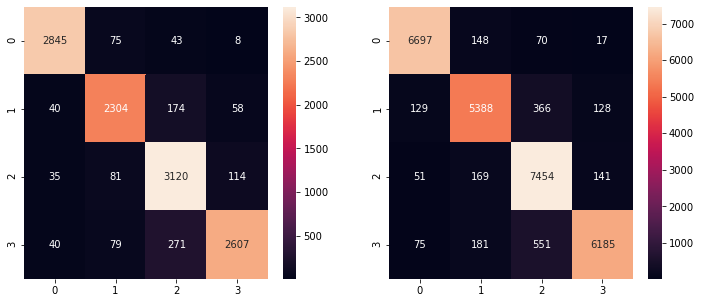

In [181]:
fig,axes = plt.subplots(1,2,figsize = (12,5))
sns.heatmap(confusion_matrix(y_test,y_test_predL),fmt = 'd',annot = True, ax = axes[0])
sns.heatmap(confusion_matrix(y_train,y_train_predL),fmt = 'd',annot = True,ax = axes[1])
plt.savefig("4 LGBM CM.png")
plt.show()

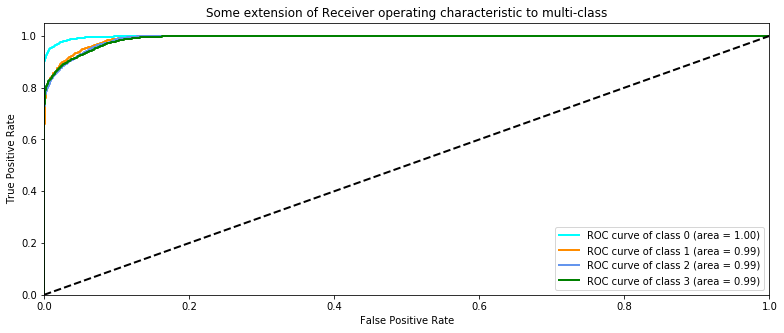

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from numpy import interp
from sklearn.metrics import roc_auc_score



y_test1 = label_binarize(y_test, classes=[0, 1, 2,3])
n_classes = 4



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_test_probL[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_test_probL.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure(figsize = (13,5))


colors = cycle(['aqua', 'darkorange', 'cornflowerblue',"green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("4 LGBM ROC.png")
plt.show()

In [308]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
scoring = {'accuracy' : make_scorer(accuracy_score)}

model_lgb = lgb.LGBMClassifier(**rsearch_lgbm.best_params_)
results_lgb = cross_validate(model_xgb, X_train, y_train, cv=10, scoring = scoring)

In [309]:
results_lgb

{'fit_time': array([1.78917408, 1.36557889, 1.36159492, 1.30773187, 1.31079602,
        1.64045715, 1.44679403, 1.42878604, 1.3056469 , 1.42376781]),
 'score_time': array([0.05337691, 0.04795384, 0.0351963 , 0.04168129, 0.03548217,
        0.03651404, 0.03518176, 0.03177905, 0.03303909, 0.0329752 ]),
 'test_accuracy': array([0.90990991, 0.90882883, 0.91027027, 0.91603604, 0.90558559,
        0.91351351, 0.89801802, 0.91531532, 0.91063063, 0.92324324])}

In [204]:
np.mean(results['test_accuracy'])

0.9105585585585585

In [210]:
np.std(results['test_accuracy'])

0.004244916561478094

In [209]:
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(results['test_accuracy']), np.std(results['test_accuracy']) * 2))

Accuracy: 0.91 (+/- 0.01)


In [230]:
import lightgbm as lgb
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

lgbc = lgb.LGBMClassifier(random_state = 3)

params = {'n_estimators' :sp_randint(70,200),
          'max_depth': sp_randint(1,10),
          'learning_rate': sp_uniform(0,0.5)}

rsearch_lgbm1 = RandomizedSearchCV(lgbc, param_distributions = params, cv = 10, n_iter=10, n_jobs = 2, scoring = ['f1_macro','precision_macro'], refit ='f1_macro')

rsearch_lgbm1.fit(X_best,y)
rsearch_lgbm1.best_params_

{'learning_rate': 0.057494386107342366, 'max_depth': 8, 'n_estimators': 165}

In [235]:
gbc_r1 = lgb.LGBMClassifier(**rsearch_lgbm1.best_params_,random_state = 3)
gbc_r1.fit(X_train1,y_train1)
y_train_predL1 = gbc_r1.predict(X_train1)
y_train_probL1 = gbc_r1.predict_proba(X_train1)

y_test_predL1 = gbc_r1.predict(X_test1)
y_test_probL1 = gbc_r1.predict_proba(X_test1)


print("Accuracy",accuracy_score(y_train1,y_train_predL1))
print("AUC train", roc_auc_score(y_train1,y_train_probL1, multi_class = "ovo"))
print("F1 train", f1_score(y_train1,y_train_predL1,average = 'weighted'))
print("recall",recall_score(y_train1,y_train_predL1,average = 'weighted'))
print("Precision",precision_score(y_train1,y_train_predL1,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test1,y_test_predL1))
print("AUC test",roc_auc_score(y_test1,y_test_probL1,multi_class = "ovo"))
print("F1 test",f1_score(y_test1,y_test_predL1,average = 'weighted'))
print("recall",recall_score(y_test1,y_test_predL1,average = 'weighted'))
print("Precision",precision_score(y_test1,y_test_predL1,average = 'weighted'))

Accuracy 0.9366846846846847
AUC train 0.9958905636121945
F1 train 0.936668266970331
recall 0.9366846846846847
Precision 0.9387623185153599


Accuracy 0.9118883470657474
AUC test 0.9926468180894111
F1 test 0.9119532798700042
recall 0.9118883470657474
Precision 0.9139604734683157


In [290]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
scoring = {'accuracy' : make_scorer(accuracy_score)}
skf = StratifiedKFold(n_splits=5,)
model3 = lgb.LGBMClassifier(**rsearch_lgbm1.best_params_)
results = cross_validate(model3, X_best, y, cv=10, scoring = scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(results['test_accuracy']), np.std(results['test_accuracy']) * 2))

Accuracy: 0.89 (+/- 0.05)


In [228]:
xgb = XGBClassifier(**random_search1.best_params_,learning_rate=0.02, n_estimators=600,
                silent=True, nthread=1)
xgb.fit(X_train1,y_train1)
y_train_predX1 = xgb.predict(X_train1)
y_train_probX1 = xgb.predict_proba(X_train1)

y_test_predX1 = xgb.predict(X_test1)
y_test_probX1 = xgb.predict_proba(X_test1)

print("Accuracy",accuracy_score(y_train1,y_train_predX1))
print("AUC train", roc_auc_score(y_train1,y_train_probX1, multi_class = "ovo"))
print("F1 train", f1_score(y_train1,y_train_predX1,average = 'weighted'))
print("recall",recall_score(y_train1,y_train_predX1,average = 'weighted'))
print("Precision",precision_score(y_train1,y_train_predX1,average = 'weighted'))

print("\n")
print("Accuracy",accuracy_score(y_test1,y_test_predX1))
print("AUC test",roc_auc_score(y_test1,y_test_probX1,multi_class = "ovo"))
print("F1 test",f1_score(y_test1,y_test_predX1,average = 'weighted'))
print("recall",recall_score(y_test1,y_test_predX1,average = 'weighted'))
print("Precision",precision_score(y_test1,y_test_predX1,average = 'weighted'))


[01:49:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy 0.9098378378378379
AUC train 0.991703847567717
F1 train 0.9098763266605797
recall 0.9098378378378379
Precision 0.9130913257183602


Accuracy 0.9007062384395493
AUC test 0.9903091826072238
F1 test 0.9007139412092144
recall 0.9007062384395493
Precision 0.9037559553180959


## XGB CROSS VAl

In [306]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
scoring = {'accuracy' : make_scorer(accuracy_score)}

model6 = XGBClassifier(**random_search1.best_params_,learning_rate=0.02, n_estimators=600,
                silent=True, nthread=1)
results = cross_validate(model6, X_train, y_train, cv=10, scoring = scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(results['test_accuracy']), np.std(results['test_accuracy']) * 2))

[16:29:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:31:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:34:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

In [301]:
results

[array([0.7012987 , 0.83116883, 0.75324675, 0.68831169, 0.76623377,
        0.74025974, 0.85714286, 0.81818182, 0.73684211, 0.80263158]),
 array([0.67532468, 0.76623377, 0.7012987 , 0.5974026 , 0.7012987 ,
        0.74025974, 0.74025974, 0.79220779, 0.63157895, 0.68421053])]

In [321]:
rb = []
rb.append(results_dt['test_accuracy'])
rb.append(resultsr['test_accuracy'])
rb.append(results['test_accuracy'])
rb.append(results_lgb['test_accuracy'])
rb

[array([0.81189189, 0.82666667, 0.81189189, 0.81045045, 0.81189189,
        0.82882883, 0.81621622, 0.8209009 , 0.81261261, 0.83063063]),
 array([0.90264817, 0.92055485, 0.88272383, 0.84867591, 0.87840565,
        0.87108981, 0.86755802, 0.89177598, 0.91246216, 0.87563068]),
 array([0.8954955 , 0.89837838, 0.90342342, 0.90306306, 0.8954955 ,
        0.90306306, 0.89333333, 0.9045045 , 0.89585586, 0.91207207]),
 array([0.90990991, 0.90882883, 0.91027027, 0.91603604, 0.90558559,
        0.91351351, 0.89801802, 0.91531532, 0.91063063, 0.92324324])]

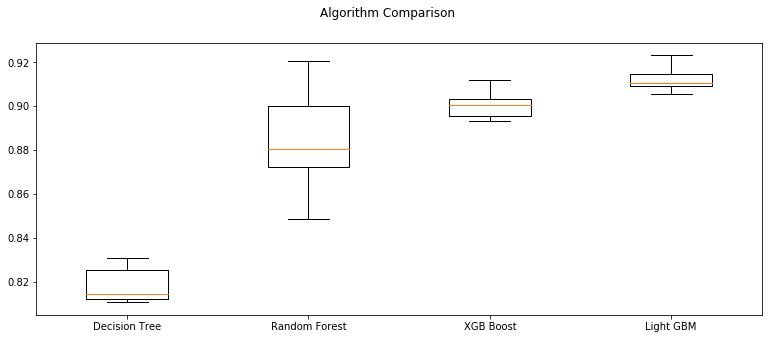

In [323]:
names = ["Decision Tree", "Random Forest", "XGB Boost", "Light GBM"]
fig = plt.figure(figsize = (13,5))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(rb,showfliers=False)
ax.set_xticklabels(names)
plt.savefig('4 BOX.png')
plt.show()